In [1]:
from fgbuster import harmonic_ilc_alm,CMB
import healpy as hp
import pysm3
import pysm3.units as u
import sys
import curvedsky as cs
import cmb
import os
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('../')
from utils import camb_clfile,cli
import mpi
import matplotlib.pyplot as plt
import pickle as pl
from database import surveys,noise

In [6]:
infolder = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/'
dnside = 512
lmax = 3*dnside -1
maskpath = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits'
fwhm = 75
cl_lenf = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
cl_len = cmb.read_camb_cls(cl_lenf,ftype='lens',output='array')[:,:lmax+1]

In [7]:
mask = hp.ud_grade(hp.read_map(maskpath),dnside)

In [15]:
class INST:
    def __init__(self,beam,frequency):
        self.Beam = beam
        self.fwhm = beam
        self.frequency = frequency
def get_cmb(idx):
    fname = os.path.join(infolder,f"cmb_sims_{idx:04d}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def get_noise_spectra(depth_i,depth_p):
    t = np.ones(lmax+1)*(np.radians(depth_i/60)**2)
    e = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    b = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    return t,e,b

def get_noise_alm(depth_i,depth_p):
    t,e,b = get_noise_spectra(depth_i,depth_p)
    t = hp.synalm(t,lmax=lmax)
    e = hp.synalm(e,lmax=lmax)
    b = hp.synalm(b,lmax=lmax)
    return t,e,b

def get_noise_map(depth_i,depth_p):
    t,e,b = get_noise_alm(depth_i,depth_p)
    return hp.alm2map([t,e,b],nside=dnside)

def get_fg(v):
    fname = os.path.join(fg_dir,f"{fg_str}_{int(v)}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def get_total_maps(idx,v,n_t,n_p,beam):
    maps = hp.smoothing(get_cmb(idx) + get_fg(v),fwhm=np.radians(beam/60)) + get_noise_map(n_t,n_p)
    return hp.map2alm(hp.smoothing(maps,np.radians(fwhm/60))*mask)

def get_maps_arr(idx,v,n_t,n_p,beam):
        arr = []
        for i in tqdm(range(len(v)),desc="Making map",unit='Freq'):
            arr.append(get_total_maps(idx,v[i],n_t[i],n_p[i],beam[i]))
        return np.array(arr)

In [16]:
sigma = 2.16
Tcmb  = 2.726e6
beam_fl = hp.gauss_beam(np.radians(fwhm/30),lmax=lmax)
Bl = np.reshape(beam_fl,(1,lmax+1))
invn = mask * (np.radians(sigma/60)/Tcmb)**-2
invN = np.reshape(np.array((invn,invn)),(2,1,hp.nside2npix(dnside)))
fg_dir = '/global/cscratch1/sd/lonappan/S4BIRD/FG'
fg_str = "s0d0"

In [17]:
table = surveys().get_table_dataframe("LITEBIRD_V1")
freqs = np.array(table.frequency)
beam = np.array(table.fwhm)
nlev_p = np.array(table.depth_p)
nlev_t = nlev_p/np.sqrt(2)

In [18]:
alms = get_maps_arr(0,freqs,nlev_t,nlev_p,beam)

Making map: 100%|██████████| 15/15 [17:20<00:00, 69.36s/Freq]


In [19]:
instrument = INST(None,freqs)
components = [CMB()]
bins = np.arange(1000) * 10

In [21]:
result1 = harmonic_ilc_alm(components, instrument,alms,bins)

In [22]:
TEB1 = [result1.s[0,0],result1.s[0,1],result1.s[0,2]]

In [23]:
TQU1 = hp.alm2map(TEB1,dnside)

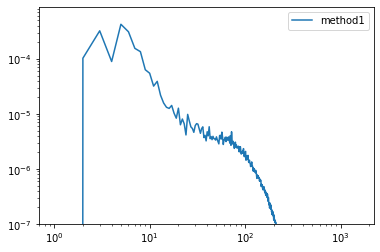

In [24]:
plt.loglog(hp.alm2cl(TEB1[2]),label='method1')
plt.ylim(10**-7,None)
plt.legend()

In [25]:
QU1 = np.reshape(np.array((TQU1[1],TQU1[2])),(2,1,hp.nside2npix(dnside)))/Tcmb

In [28]:
invn = mask * (np.radians(sigma/60)/Tcmb)**-2
invN = np.reshape(np.array((invn,invn)),(2,1,hp.nside2npix(dnside)))

In [29]:
cl_lenf = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
cl_len = cmb.read_camb_cls(cl_lenf,ftype='lens',output='array')[:,:lmax+1]

In [30]:
E1,B1 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN,QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status1.txt')


/tmp/ipykernel_2000/2563305217.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


(100000000000000000, 1.085223820390967e+37)

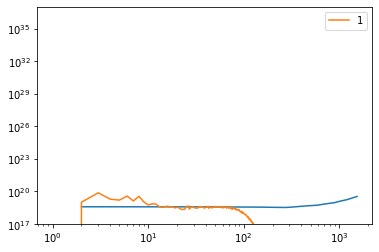

In [31]:
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B1),label='1')
plt.legend()
plt.ylim(10**17,None)

In [33]:
TQU_woFG1 = hp.smoothing((hp.smoothing(get_cmb(0),fwhm=np.radians(30/60)) + get_noise_map(1.5,sigma)),fwhm=np.radians(fwhm/60))*mask

In [34]:
TEB_woFG1 = hp.map2alm(TQU_woFG1)

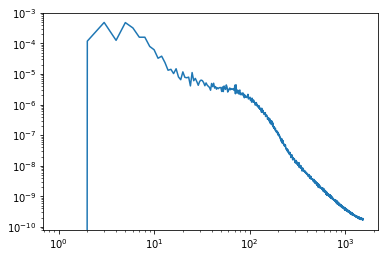

In [35]:
plt.loglog(hp.alm2cl(TEB_woFG1[2]))

In [36]:
QU_woFG1 = np.reshape(np.array((TQU_woFG1[1],TQU_woFG1[2])),(2,1,hp.nside2npix(dnside)))/Tcmb

In [37]:
E_noFG1,B_noFG1 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN,QU_woFG1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status1.txt')



/tmp/ipykernel_2000/2486428330.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


(0.692938323521023, 200)

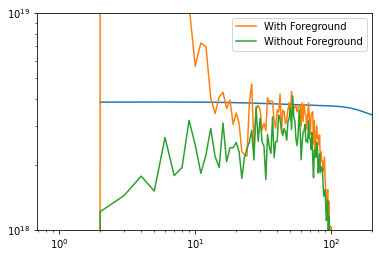

In [43]:
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B1),label='With Foreground')
plt.loglog(cs.utils.alm2cl(lmax,B_noFG1),label='Without Foreground')
plt.legend()
plt.ylim(10**18,10**19)
plt.xlim(None,200)

/tmp/ipykernel_2000/363174523.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,B1)/cs.utils.alm2cl(lmax,B_noFG1))
/tmp/ipykernel_2000/363174523.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,B1)/cs.utils.alm2cl(lmax,B_noFG1))
/tmp/ipykernel_2000/363174523.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,E1)/cs.utils.alm2cl(lmax,E_noFG1))
/tmp/ipykernel_2000/363174523.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,E1)/cs.utils.alm2cl(lmax,E_noFG1))
/tmp/ipykernel_2000/363174523.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,200)


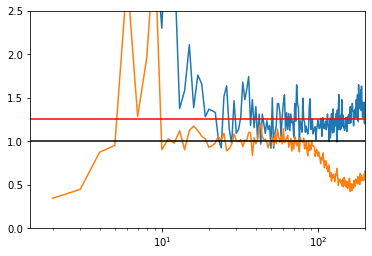

In [57]:
plt.plot(cs.utils.alm2cl(lmax,B1)/cs.utils.alm2cl(lmax,B_noFG1))
plt.plot(cs.utils.alm2cl(lmax,E1)/cs.utils.alm2cl(lmax,E_noFG1))
plt.semilogx()
plt.ylim(0,2.5)
plt.xlim(0,200)
plt.axhline(1.25,c='r')
plt.axhline(1,c='k')

In [58]:
Nl_P = []
for b,n in zip(beam,np.radians(nlev_p/60)**2):
    Nl_P.append(np.ones(lmax+1)*n)
Nl_P = np.array(Nl_P)

In [61]:
w_bb = result1.W[2]
nl_bb = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_bb[i] = np.dot(Nl_P[:, i], w_bb[i][0]**2)
    

w_ee = result1.W[1]
nl_ee = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_ee[i] = np.dot(Nl_P[:, i], w_ee[i][0]**2)

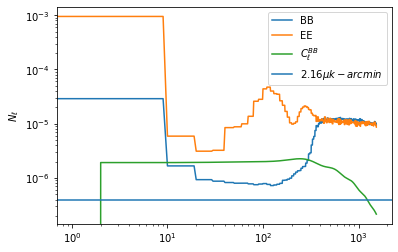

In [63]:
plt.loglog(nl_bb,label='BB')
plt.loglog(nl_ee,label='EE')
plt.loglog(cl_len[2,:]*Tcmb**2,label='$C_\ell^{BB}$')
plt.axhline(np.radians(2.16/60)**2,label='$2.16 \mu k -arcmin$')
plt.ylabel("$N_\ell$")
plt.legend()

In [64]:
NL = np.reshape(np.array((cli(nl_ee[:lmax+1]/Tcmb**2),cli(nl_bb[:lmax+1]/Tcmb**2))),(2,1,lmax+1))

In [66]:
E4,B4 = cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],
                Bl,np.reshape(np.array((mask,mask)),(2,1,hp.nside2npix(dnside))),QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,inl=NL,stat='statues.txt')




/tmp/ipykernel_2000/1252749084.py:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


(0.692938323521023, 200)

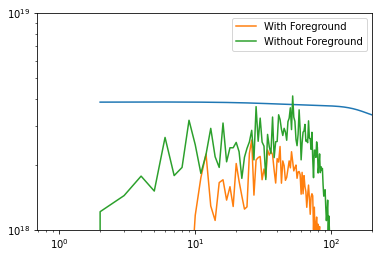

In [67]:
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B4),label='With Foreground')
plt.loglog(cs.utils.alm2cl(lmax,B_noFG1),label='Without Foreground')
plt.legend()
plt.ylim(10**18,10**19)
plt.xlim(None,200)

/tmp/ipykernel_2000/1719427221.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,B4)/cs.utils.alm2cl(lmax,B_noFG1))
/tmp/ipykernel_2000/1719427221.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,E4)/cs.utils.alm2cl(lmax,E_noFG1))
/tmp/ipykernel_2000/1719427221.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,200)


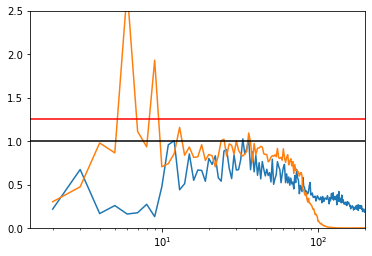

In [68]:
plt.plot(cs.utils.alm2cl(lmax,B4)/cs.utils.alm2cl(lmax,B_noFG1))
plt.plot(cs.utils.alm2cl(lmax,E4)/cs.utils.alm2cl(lmax,E_noFG1))
plt.semilogx()
plt.ylim(0,2.5)
plt.xlim(0,200)
plt.axhline(1.25,c='r')
plt.axhline(1,c='k')

In [69]:
table

,level_0,index,frequency,depth_p,fwhm,bandwidth,pixel_size,detectors,net_det,net_arr_t,net_arr_p
0,0,0,40.0,37.42,70.5,0.30,18.0,114,172,18.0,25.5
1,1,1,50.0,33.46,58.5,0.30,18.0,114,96,11.5,16.3
2,2,2,60.0,21.31,51.1,0.23,18.0,114,79,9.5,13.5
3,3,3,68.0,16.87,47.1,0.23,18.0,114,64,7.8,11.0
4,4,4,78.0,12.07,43.8,0.23,18.0,114,54,6.5,9.2
5,5,5,89.0,11.30,41.5,0.23,18.0,114,47,5.6,8.0
6,6,6,100.0,6.56,37.8,0.23,12.0,296,59,4.4,6.2
7,7,7,119.0,4.58,33.6,0.30,12.0,222,42,3.7,5.2
8,8,8,140.0,4.79,30.8,0.30,12.0,296,38,2.8,4.0
9,9,9,166.0,5.57,28.9,0.30,12.0,222,36,3.1,4.4


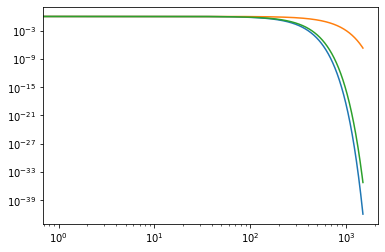

In [6]:
plt.loglog(hp.gauss_beam(np.radians(75/60),lmax=1500))
plt.loglog(hp.gauss_beam(np.radians(30/60),lmax=1500))
plt.loglog(hp.gauss_beam(np.radians(75/60),lmax=1500)/hp.gauss_beam(np.radians(30/60),lmax=1500))